In [1]:
import json
import os
import shutil
import time
import warnings
from pprint import pprint
import datetime

In [2]:
import gensim.parsing.preprocessing as gsp
import joblib
import matplotlib.pyplot as plt
import mlflow
import nltk
import numpy as np
import pandas as pd
import tensorflow_hub as hub
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from mlflow.models import infer_signature
from nltk import WordNetLemmatizer, PorterStemmer
from pandas import DataFrame
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import *
from xgboost import XGBClassifier

2024-09-02 17:16:48.557098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 17:16:48.611503: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 17:16:48.627455: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 17:16:48.725273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 17:16:49.816118: W tensorflow/compiler/tf2

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

MISC CONFIGURATION

In [4]:
plt.style.use("fivethirtyeight")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

NUMBER_OF_QUESTIONS_USED_IN_TRAINING = 10000

PATHS

In [5]:
CACHED_QUESTIONS_FILE = '../cached_questions.json'
MODELS_PATH = '../inferring_api/models'

NLTK PACKAGES

In [6]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/xavier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/xavier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

NLTK OBJECTS

In [7]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

To avoid having multiprocessing issues between BERT and the GridsearchCV

In [8]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [9]:
def load_cached_questions():
    """Load questions from the cache file."""
    with open(CACHED_QUESTIONS_FILE, 'r', encoding='utf-8') as f:
        return json.load(f)

In [10]:
def remove_last_saved_model():
    """Removes the content of the saved model."""
    shutil.rmtree(MODELS_PATH, ignore_errors=True)
    os.makedirs(MODELS_PATH, exist_ok=True)

In [11]:
def extract_and_clean_text(question: dict):
    """Create a new 'text' field for each question containing the cleaned, tokenized and lemmatized title + body."""
    title = question['title']
    body = question['body']
    text = f"{title} {body}"
    
    for filter in [gsp.strip_tags,
                   gsp.strip_punctuation,
                   gsp.strip_multiple_whitespaces,
                   gsp.strip_numeric,
                   gsp.remove_stopwords,
                   gsp.strip_short,
                   gsp.lower_to_unicode]:
        text = filter(text)
        
    tokenized_text = nltk.tokenize.word_tokenize(text)

    # words_stemmed = (stemmer.stem(w) for w in words_without_short_words)
    words_lemmatized = [lemmatizer.lemmatize(w) for w in tokenized_text]
    question['text'] = " ".join(words_lemmatized)

    # bigrams = nltk.bigrams(tokenized_text)
    # question['bigrams'] = [' '.join(bigram) for bigram in bigrams]

    # trigrams = nltk.trigrams(tokenized_text)
    # question['trigrams'] = [' '.join(trigram) for trigram in trigrams]
    
    return question

In [12]:
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    """Returns BERT variables for its prediction."""
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []
    
    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
        
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))
        
    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot

In [13]:
def transform_text_using_BERT(model, model_type, sentences, max_length, b_size):
    """Transform the text of the question's body and title into BERT embeddings."""
    # We don't want to use the cleaned text field with BERT, only title + " " + body
    sentences = [f"{sentence[1]} {sentence[0]}" for sentence in sentences.iterrows()]
    
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    
    time1 = time.time()
    for step in range(len(sentences) // batch_size):
        idx = step * batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx + batch_size],
                                                                               bert_tokenizer, max_length)
        outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
        
        last_hidden_states = outputs.last_hidden_state
        if step == 0:
            last_hidden_states_tot = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot, last_hidden_states))
            
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1, 0)
    print(f"BERT processing time:{time2}s\n")
    
    return features_bert, time2

In [14]:
def transform_text_using_USE(sentences, b_size):
    """Transform the text of the question's body and title into USE embeddings."""
    # We don't want to use the cleaned text field with USE, only title + " " + body
    sentences = [f"{sentence[1]} {sentence[0]}" for sentence in sentences.iterrows()]
    
    batch_size = b_size
    time1 = time.time()
    
    us_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    
    for step in range(len(sentences) // batch_size):
        idx = step * batch_size
        feat = us_encoder(sentences[idx:idx + batch_size])
        
        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))
            
    time2 = np.round(time.time() - time1, 0)
    print(f"USE processing time:{time2}s\n")
    
    return features, time2

In [15]:
def transform_text(questions_without_tags, text_transformation_method):
    """Transform the question text/body and title into words embeddings."""
    if text_transformation_method == "Doc2VEC":
        return transform_text_using_Doc2VEC(questions_without_tags["text"])
        
    elif text_transformation_method == "BERT":
        max_length = 64
        batch_size = 10
        model_type = 'bert-base-uncased'
        model = TFAutoModel.from_pretrained(model_type)
        
        return transform_text_using_BERT(model, model_type, questions_without_tags, max_length, batch_size)
        
    elif text_transformation_method == "USE":
        batch_size = 10
        return transform_text_using_USE(questions_without_tags, batch_size)

In [16]:
def transform_text_using_Doc2VEC(questions_without_tags):
    """Transform the text of the question's body and title into Doc2VEC embeddings."""
    time1 = time.time()
    tagged_text = [TaggedDocument(words=text, tags=[str(index)])
                   for index, text in enumerate(questions_without_tags)]

    # dm=0 for DBOW, dm=1 for PV-DM
    model = Doc2Vec(vector_size=30, min_count=2, epochs=80, dm=0)
    model.build_vocab(tagged_text)
    
    model.train(tagged_text, total_examples=model.corpus_count, epochs=model.epochs)
    embedded_text = [model.infer_vector(text.split(" ")) for text in questions_without_tags]
    
    time2 = np.round(time.time() - time1, 0)
    print(f"Doc2VEC processing time:{time2}s\n")
    
    return embedded_text, time2

In [17]:
def create_results_plot(results):
    """Generate the plot showing the performances with each words embedding method for the Jaccard Score and Hamming Loss."""
    results.sort_values(f"jaccard_score", ascending=False, inplace=True)
    performance_plot = (results[["jaccard_score", "words_embedding_method"]]
                        .plot(kind="bar", x="words_embedding_method", figsize=(15, 8), rot=0,
                                    title="Models Performance Sorted by Jaccard Score"))
    performance_plot.title.set_size(20)
    performance_plot.set(xlabel=None)
    # performance_plot.get_figure().savefig(f"{RESULTS_PATH}/performance_jaccard_score_plot.png", bbox_inches='tight')
    plt.show()
    plt.close()

    results.sort_values(f"hamming_loss", ascending=True, inplace=True)
    performance_plot = (results[["hamming_loss", "words_embedding_method"]]
                        .plot(kind="bar", x="words_embedding_method", figsize=(15, 8), rot=0,
                                    title="Models Performance Sorted by Hamming Loss"))
    performance_plot.title.set_size(20)
    performance_plot.set(xlabel=None)
    # performance_plot.get_figure().savefig(f"{RESULTS_PATH}/performance_hamming_loss_plot.png", bbox_inches='tight')
    plt.show()
    plt.close()

In [18]:
def perform_supervised_modeling(questions):
    """Find the best model using a GridSearchCV hyperoptimization for each words embedding method."""
    questions_df = DataFrame(questions).head(NUMBER_OF_QUESTIONS_USED_IN_TRAINING)

    tags = MultiLabelBinarizer().fit_transform(questions_df['tags'])
    questions_df['tags'].to_json(f"{MODELS_PATH}/tags.json")

    questions_without_tags = questions_df.drop(columns=['tags'], axis=1)

    results_df = DataFrame(columns=["words_embedding_method", "hamming_loss", "jaccard_score"])
    models = {}
    for words_embedding_method in [
        "Doc2VEC",
        "BERT",
        "USE"
    ]:
        print(f"Starting supervised learning of {NUMBER_OF_QUESTIONS_USED_IN_TRAINING} questions with words embedding method:{words_embedding_method}.\n")
        transformed_text, embedding_time = transform_text(questions_without_tags, words_embedding_method)

        x_train, x_test, y_train, y_test = train_test_split(transformed_text, tags, test_size=0.2, random_state=42)
        print(f"training set size:{len(x_train)}, test set size:{len(x_test)}\n")

        # XGBClassifier has a Jaccard Score 10x better than the RandomForestClassifier
        # Best hyperparameter for 10k questions
        default_model = XGBClassifier(n_estimators=100, max_depth=2, device='cuda')
        default_hyperparameters = {'estimator__max_depth': range(2, 6)}

        fit_start_time = time.time()
        grid_search_cv = GridSearchCV(MultiOutputClassifier(estimator=default_model), default_hyperparameters,
                                      cv=2,
                                      scoring=make_scorer(metrics.jaccard_score, average='samples'),
                                      n_jobs=1,  # With cuda it's best to not parallelize jobs or -> cudaErrorMemoryAllocation
                                      verbose=3
                                      )
        
        grid_search_cv.fit(x_train, y_train)
        best_model = grid_search_cv.best_estimator_

        best_parameters = grid_search_cv.best_params_
        print(f"\nBest Jaccard score:{grid_search_cv.best_score_} with params:{best_parameters}")

        # In case of training of the model
        # default_model.fit(x_train, y_train)
        # best_model = default_model
        
        fit_time = np.round(time.time() - fit_start_time, 0)
        
        models[words_embedding_method] = best_model
        predictions_test_y = best_model.predict(x_test)

        hamming_loss = metrics.hamming_loss(y_true=y_test, y_pred=predictions_test_y)
        jaccard_score = metrics.jaccard_score(y_true=y_test, y_pred=predictions_test_y, average='samples')
        print(f"Hamming loss:{hamming_loss}, jaccard_score:{jaccard_score}\n")

        # training set size:36000, test set size:9000, XGBClassifier
        # Hamming loss:0.0002497610080278267, jaccard_score:0.30443386243386245

        results_df.loc[len(results_df)] = [words_embedding_method, hamming_loss, jaccard_score]

        send_results_to_mlflow(default_hyperparameters, best_model, hamming_loss, jaccard_score,
                               words_embedding_method, x_train, embedding_time, fit_time)

    create_results_plot(results_df)

    save_best_model(models, results_df)

In [19]:
def save_best_model(models, results_df):
    """Save the best model based on the hamming loss."""
    best_words_embedding_method = results_df.head(1)['words_embedding_method'].values[0]
    joblib.dump(models[best_words_embedding_method], f"{MODELS_PATH}/best_supervised_model.model")

In [20]:
def send_results_to_mlflow(default_hyperparameters, best_model, hamming_loss, jaccard_score, words_embedding_method,
                           x_train, embedding_time, fit_time):
    """Send data to the MLFlow server."""
    with mlflow.start_run():
        mlflow.log_params(default_hyperparameters)
        
        mlflow.log_metric("hamming_loss", hamming_loss)
        mlflow.log_metric("jaccard_score", jaccard_score)
        mlflow.log_metric("embedding_time", embedding_time)
        mlflow.log_metric("fitting_time", fit_time)
        
        mlflow.set_tag("Words embedding method", words_embedding_method)
        
        signature = infer_signature(x_train, best_model.predict(x_train))
        
        mlflow.sklearn.log_model(
            sk_model=best_model,
            artifact_path="supervised-models",
            signature=signature,
            input_example=x_train,
            registered_model_name="XGBoostClassifier",
        )

2024/09/02 17:16:52 INFO mlflow.tracking.fluent: Experiment with name 'Supervised Learning Experiment' does not exist. Creating a new experiment.


Starting supervised learning script. Please make sure you have a local MLFlow server running, the README file has more information about this.

10000 questions loaded from cache.

Texts extracted and cleaned.

Starting supervised learning of 10000 questions with words embedding method:Doc2VEC.

Doc2VEC processing time:54.0s

training set size:8000, test set size:2000

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:36:22] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:36:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure 

[CV 1/2] END ............estimator__max_depth=2;, score=0.001 total time=79.6min
[CV 2/2] END ............estimator__max_depth=2;, score=0.001 total time=79.7min
[CV 1/2] END ............estimator__max_depth=3;, score=0.001 total time=80.7min
[CV 2/2] END ............estimator__max_depth=3;, score=0.002 total time=80.7min
[CV 1/2] END ............estimator__max_depth=4;, score=0.002 total time=81.0min
[CV 2/2] END ............estimator__max_depth=4;, score=0.001 total time=81.0min

Best Jaccard score:0.0017291666666666666 with params:{'estimator__max_depth': 5}


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:43:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 2/2] END ............estimator__max_depth=5;, score=0.001 total time=81.1min
[CV 1/2] END ............estimator__max_depth=5;, score=0.002 total time=81.1min
Hamming loss:0.0007293886058360352, jaccard_score:0.0013416666666666666



2024/09/02 18:45:28 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp7j6ss2c4/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
Successfully registered model 'XGBoostClassifier'.
2024/09/02 18:45:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostClassifier, version 1
Created version '1' of model 'XGBoostClassifier'.
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

2024/09/02 18:45:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run rogue-mink-529 at: ht

Starting supervised learning of 10000 questions with words embedding method:BERT.



loading configuration file config.json from cache at /home/xavier/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /home/xavier/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f72

1/1 [==============================] - 0s 19ms/step
BERT processing time:206.0s

training set size:8000, test set size:2000

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 2/2] END ..............estimator__max_depth=3;, score=nan total time=   1.9s
[CV 2/2] END ..............estimator__max_depth=2;, score=nan total time=   1.9s
[CV 1/2] END ..............estimator__max_depth=4;, score=nan total time=   2.2s
[CV 1/2] END ..............estimator__max_depth=2;, score=nan total time=   3.1s
[CV 2/2] END ..............estimator__max_depth=5;, score=nan total time=   3.0s
[CV 1/2] END ..............estimator__max_depth=5;, score=nan total time=   4.1s
[CV 2/2] END ..............estimator__max_depth=4;, score=nan total time= 1.6min


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:23:57] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
7 fits failed out of a total of 8.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------

[CV 1/2] END ............estimator__max_depth=3;, score=0.111 total time=37.3min

Best Jaccard score:nan with params:{'estimator__max_depth': 2}
Hamming loss:0.0006604909680407597, jaccard_score:0.13907142857142857



2024/09/02 19:47:44 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp75jri0sc/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
Registered model 'XGBoostClassifier' already exists. Creating a new version of this model...
2024/09/02 19:47:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostClassifier, version 2
Created version '2' of model 'XGBoostClassifier'.
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

2024/09/02 19:48:19 INFO mlflow.tracking._tracking_servic

Starting supervised learning of 10000 questions with words embedding method:USE.

USE processing time:37.0s

training set size:8000, test set size:2000

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 2/2] END ..............estimator__max_depth=5;, score=nan total time=   2.1s
[CV 2/2] END ..............estimator__max_depth=4;, score=nan total time=   2.1s
[CV 1/2] END ..............estimator__max_depth=2;, score=nan total time=   2.3s
[CV 1/2] END ..............estimator__max_depth=4;, score=nan total time=  51.1s


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:39:15] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:39:27] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure 

[CV 2/2] END ............estimator__max_depth=2;, score=0.247 total time=52.6min
[CV 2/2] END ............estimator__max_depth=3;, score=0.239 total time=52.8min
[CV 1/2] END ............estimator__max_depth=3;, score=0.250 total time=53.0min
[CV 1/2] END ............estimator__max_depth=5;, score=0.243 total time=53.0min

Best Jaccard score:0.24437619047619047 with params:{'estimator__max_depth': 3}
Hamming loss:0.0005856878184344604, jaccard_score:0.2783404761904762



Registered model 'XGBoostClassifier' already exists. Creating a new version of this model...
2024/09/02 20:57:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostClassifier, version 3
Created version '3' of model 'XGBoostClassifier'.
2024/09/02 21:00:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run melodic-swan-576 at: http://localhost:8080/#/experiments/514120375666843894/runs/e611cfd271374a86bca6c6fb20073955.
2024/09/02 21:00:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/514120375666843894.


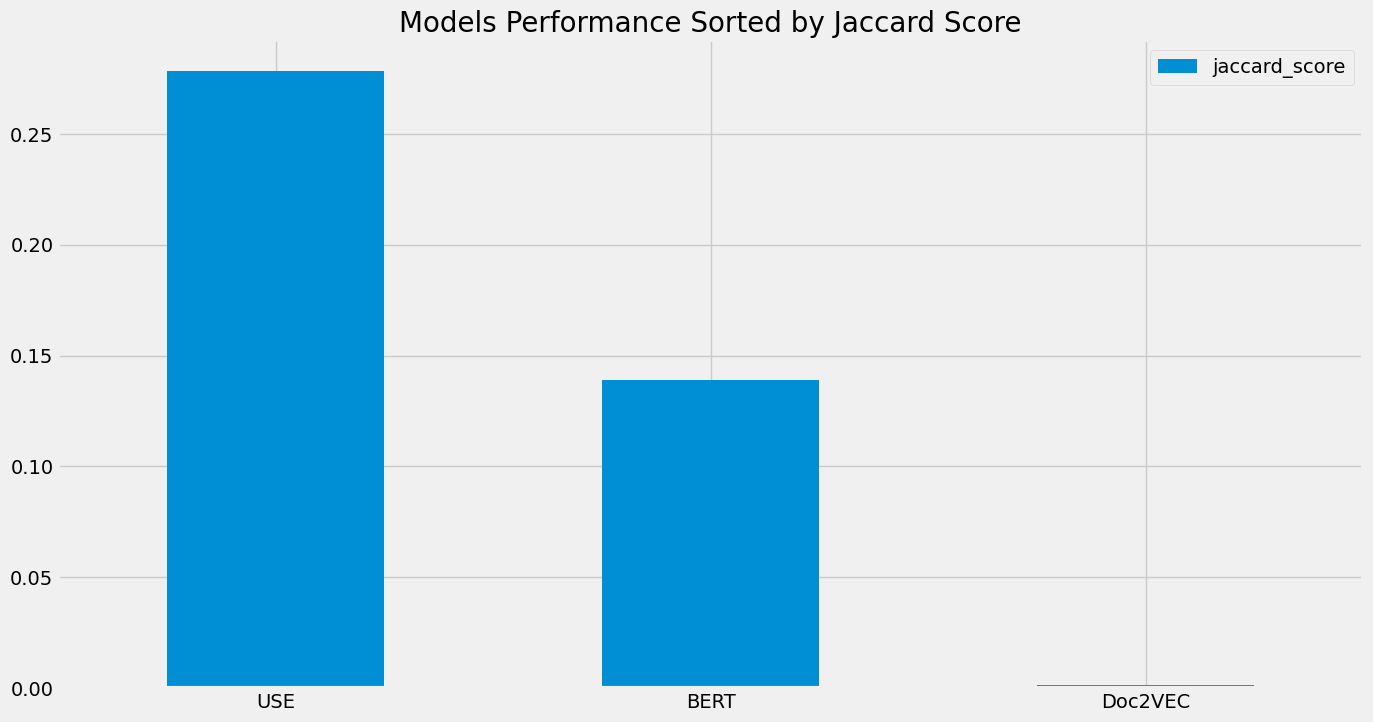

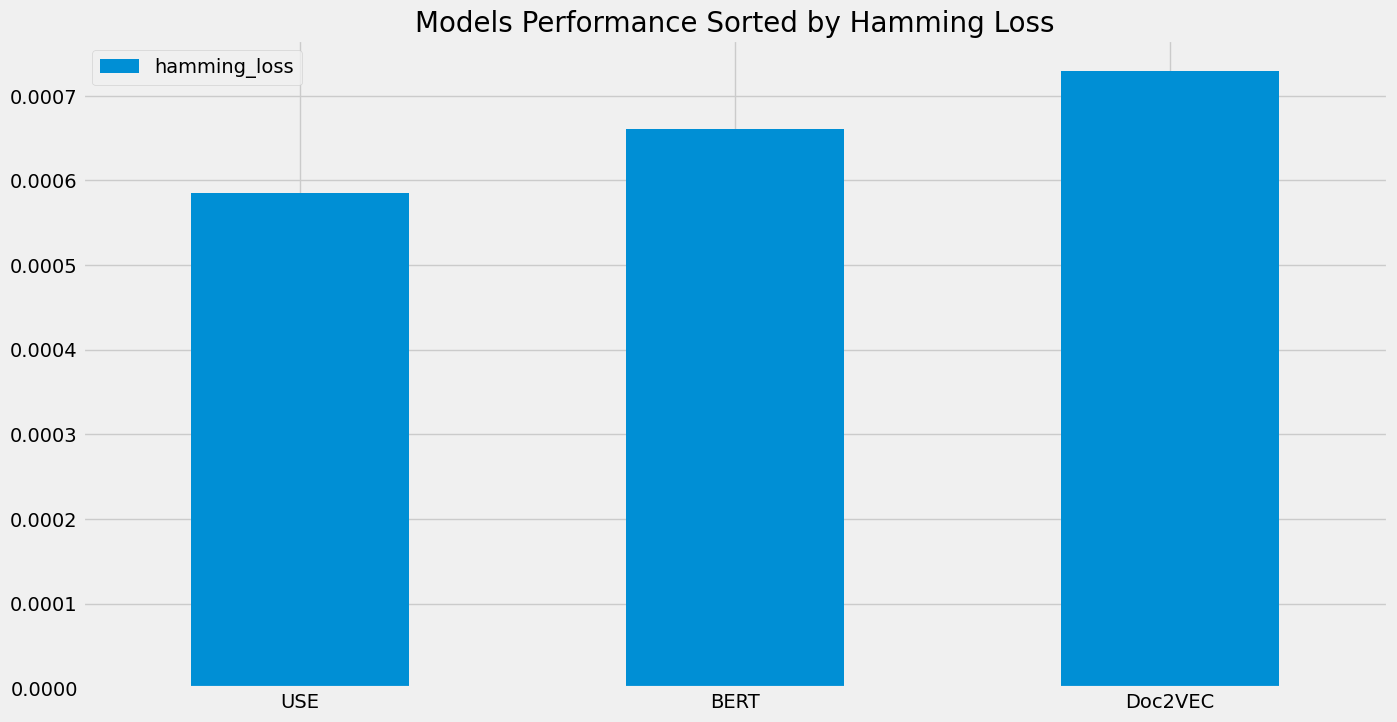


Supervised learning now finished.



In [21]:
print("Starting supervised learning script. Please make sure you have a local MLFlow server running, the README file has more information about this.\n")
remove_last_saved_model()

mlflow.set_tracking_uri(uri="http://localhost:8080")
mlflow.set_experiment("Supervised Learning Experiment")

json_questions = load_cached_questions()

questions = [{
    "body": question['body'],
    "tags": question['tags'],
    "title": question['title']
} for question in json_questions[:NUMBER_OF_QUESTIONS_USED_IN_TRAINING]]

print(f"{len(questions)} questions loaded from cache.\n")

questions = list(map(extract_and_clean_text, questions))
print("Texts extracted and cleaned.\n")

perform_supervised_modeling(questions)

print("\nSupervised learning now finished.\n")